# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

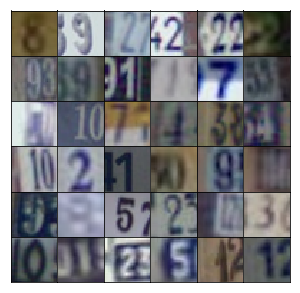

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), self.scaler(y)

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):

        x = tf.layers.dense(inputs=z, units=4*4*512, activation=None)
        x = tf.reshape(x, [-1, 4, 4, 512])
        x = tf.maximum(x * alpha, x)
        # Image is 4x4x512

        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Image is 8x8x256

        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Image is 16x16x64
        
        x = tf.layers.conv2d_transpose(x, output_dim, 5, strides=2, padding='same')
        out = tf.tanh(x)
        # Image is 32x32xOutput_dim
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First convolutional layer, Input layer is 32x32x3
        x = tf.layers.conv2d(x, 32, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        x = tf.layers.batch_normalization(x)
        x = tf.maximum(x * alpha, x)
        # Image is 16x16x32

        x = tf.layers.conv2d(x, 64, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        x = tf.layers.batch_normalization(x)
        x = tf.maximum(x * alpha, x)
        # Image is 8x8x64
        
        x = tf.layers.conv2d(x, 128, kernel_size=[5,5], strides=[2,2], padding='same', activation=None)
        x = tf.layers.batch_normalization(x)
        x = tf.maximum(x * alpha, x)
        # Image is 4x4x128
        
        x = tf.reshape(x, [-1, 1024])
        logits = tf.layers.dense(inputs=x, units=1, activation=None)
        out = tf.tanh(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Again, nothing new here.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network.

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 5, 10, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.001
batch_size = 64
epochs = 1
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.5489


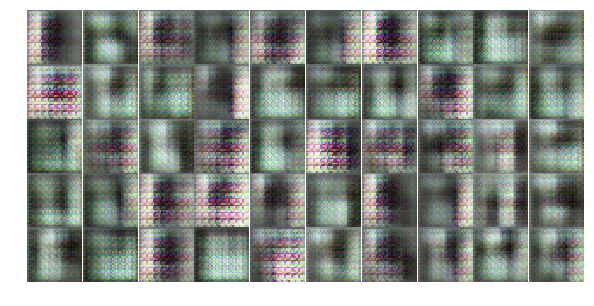

Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9079


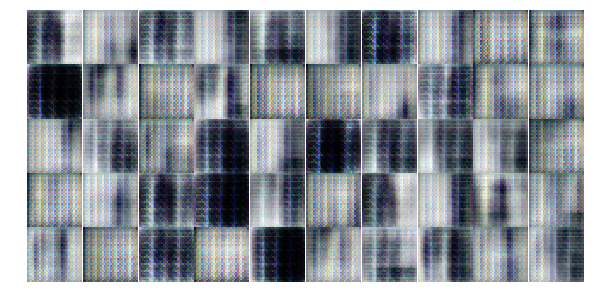

Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8731


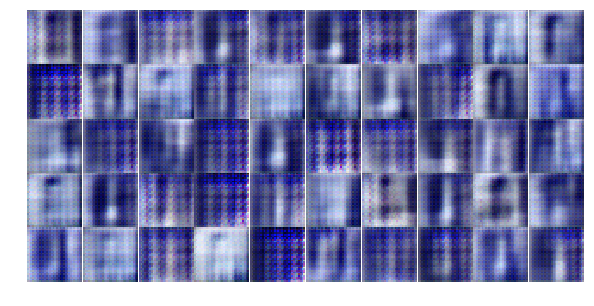

Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7082


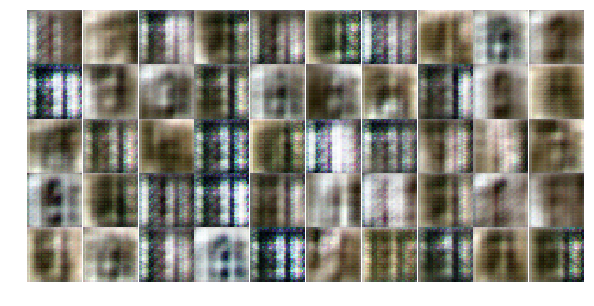

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7953


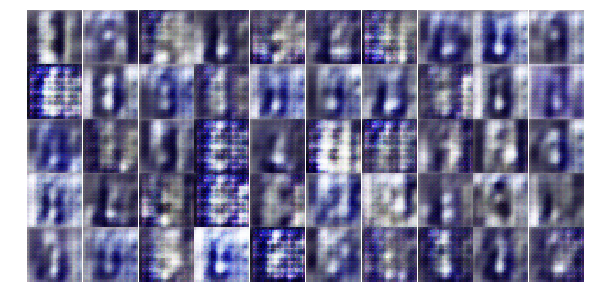

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8504


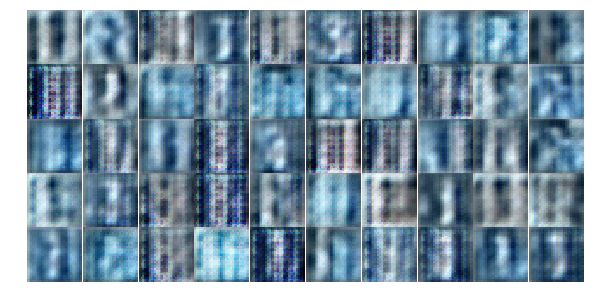

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7288


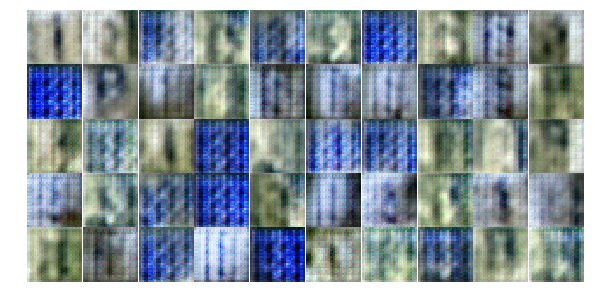

Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8322


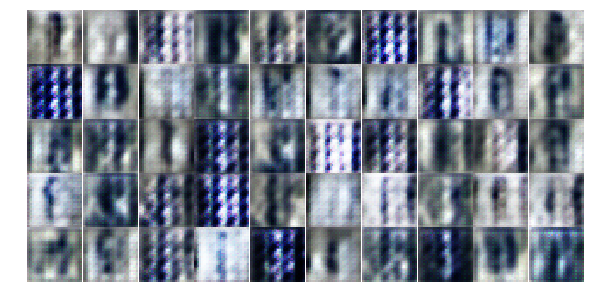

Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7773


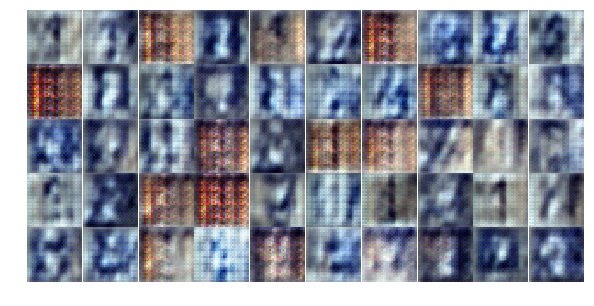

Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8071


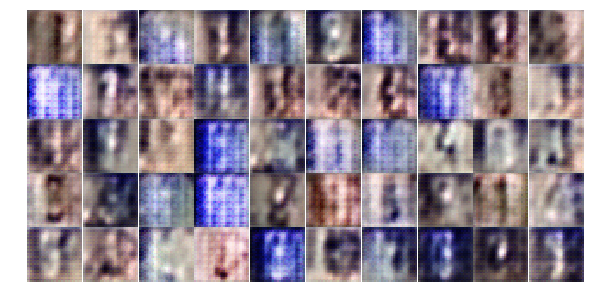

Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7748


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))